In [1]:
from typing import Tuple

import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

# Test data

In [2]:
h = 1  # discretization step in s
g = 0.1  # gravity in m/s^2
m = 10.0  # mass in kg
F_max = 10.0  # maximum thrust in Newton
p0 = np.array([50, 50, 100])  # initial position in m
v0 = np.array([-10, 0, -10])  # initial velocity in m/s
p_target = np.array([0, 0, 0])  # target position in m
alpha = np.pi / 8  # glide angle in rad
gamma = 1.0  # fuel consumption coefficient
K = 35  # number of discretization steps

# Formulate the optimization problem

In [3]:
def optimize_fuel(
    p_target: np.ndarray,
    g: float,
    m: float,
    p0: np.ndarray,
    v0: np.ndarray,
    K: int,
    h: float,
    F_max: float,
    alpha: float,
    gamma: float,
    **kwargs: dict,
) -> Tuple[np.ndarray, np.ndarray]:
    """

    Minimize fuel consumption for a rocket to land on a target

    :param p_target: landing target in m
    :param g: gravitational acceleration in m/s^2
    :param m: mass in kg
    :param p0: position in m
    :param v0: velocity in m/s
    :param K: Number of discretization steps
    :param h: discretization step in s
    :param F_max: maximum thrust of engine in kg*m/s^2 (Newton)
    :param alpha: Glide path angle in radian
    :param gamma: converts fuel consumption to liters of fuel consumption
    :return: position and thrust over time
    """

    P_min = p_target[2]

    # Variables
    V = cp.Variable((K + 1, 3))  # velocity
    P = cp.Variable((K + 1, 3))  # position
    F = cp.Variable((K, 3))  # thrust

    # Constraints
    # Match initial position and initial velocity
    constraints = [
        V[0] == v0,
        P[0] == p0,
    ]

    # Keep height above P_min
    constraints += [P[:, 2] >= P_min]

    # Match final position and 0 velocity
    constraints += [
        V[K] == [0, 0, 0],
        P[K] == p_target,
    ]

    # Physics dynamics for velocity
    constraints += [V[1:, :2] == V[:-1, :2] + h * (F[:, :2] / m)]
    constraints += [V[1:, 2] == V[:-1, 2] + h * (F[:, 2] / m - g)]

    # Physics dynamics for position
    constraints += [P[1:] == P[:-1] + (h / 2) * (V[:-1] + V[1:])]

    # Glide path constraint
    constraints += [P[:, 2] >= np.tan(alpha) * cp.norm(P[:, :2], axis=1)]

    # Maximum thrust constraint
    constraints += [cp.norm(F, 2, axis=1) <= F_max]

    fuel_consumption = gamma * cp.sum(cp.norm(F, axis=1))

    problem = cp.Problem(cp.Minimize(fuel_consumption), constraints)
    problem.solve(**kwargs)
    return P.value, F.value

# Solve the problem

In [4]:
P_star, F_star = optimize_fuel(
    p_target, g, m, p0, v0, K, h, F_max, alpha, gamma
)

# Plot the trajectory

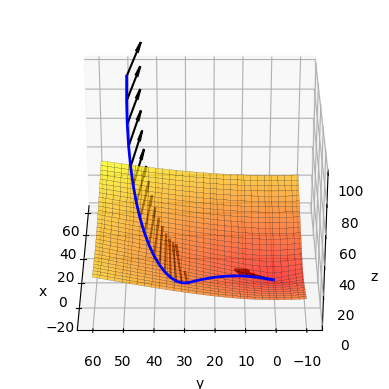

In [5]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
X = np.linspace(P_star[:, 0].min() - 10, P_star[:, 0].max() + 10, num=30)
Y = np.linspace(P_star[:, 1].min() - 10, P_star[:, 1].max() + 10, num=30)
X, Y = np.meshgrid(X, Y)
Z = np.tan(alpha) * np.sqrt(X**2 + Y**2)
ax.plot_surface(
    X,
    Y,
    Z,
    rstride=1,
    cstride=1,
    cmap=cm.autumn,
    linewidth=0.1,
    alpha=0.7,
    edgecolors="k",
)
ax = plt.gca()
ax.view_init(azim=180)
ax.plot(xs=P_star[:, 0], ys=P_star[:, 1], zs=P_star[:, 2], c="b", lw=2, zorder=5)

ax.quiver(
    P_star[:-1, 0],
    P_star[:-1, 1],
    P_star[:-1, 2],
    F_star[:, 0],
    F_star[:, 1],
    F_star[:, 2],
    zorder=5,
    color="black",
    length=2,
)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

# Plot the Position, Velocity and Thrust over time

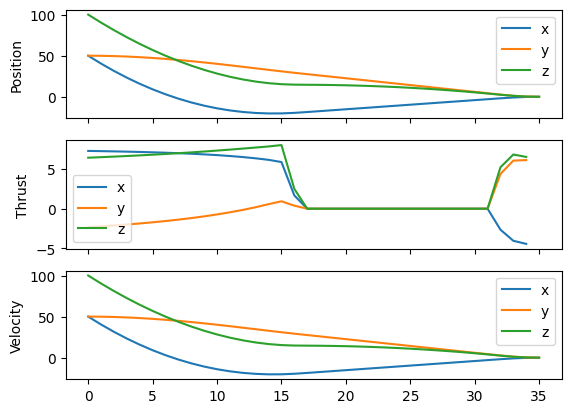

In [6]:
fig, ax = plt.subplots(3, 1, sharex=True)

ax[0].plot(P_star[:, 0], label="x")
ax[0].plot(P_star[:, 1], label="y")
ax[0].plot(P_star[:, 2], label="z")
ax[0].set_ylabel("Position")
ax[0].legend()

ax[1].plot(F_star[:, 0], label="x")
ax[1].plot(F_star[:, 1], label="y")
ax[1].plot(F_star[:, 2], label="z")
ax[1].set_ylabel("Thrust")
ax[1].legend()

ax[2].plot(P_star[:, 0], label="x")
ax[2].plot(P_star[:, 1], label="y")
ax[2].plot(P_star[:, 2], label="z")
ax[2].set_ylabel("Velocity")
ax[2].legend()

plt.show()